# 코로나 확진 예측

1. 이진 분류 데이터 세트 수집
2. 탐색(시각화)
3. 전처리(비중): 10% 넘으면 대체
4. 데이터 세트 분리(stratify=True)
5. GridSearchCV(DTC) : 일단 훈련 후 판단
6. fit: graphviz
7. predict
8. 오차 행렬
9. proba
10. 정밀도, 재현율 수립
11. cuv -> thresholds
12. 조정
13. 테스트

In [1]:
import pandas as pd

co_df  = pd.read_csv('./datasets/covid.csv')
co_df

id  sex  patient_type  entry_date date_symptoms   date_died  \
0       16169f    2             1  04-05-2020    02-05-2020  9999-99-99   
1       1009bf    2             1  19-03-2020    17-03-2020  9999-99-99   
2       167386    1             2  06-04-2020    01-04-2020  9999-99-99   
3       0b5948    2             2  17-04-2020    10-04-2020  9999-99-99   
4       0d01b5    1             2  13-04-2020    13-04-2020  22-04-2020   
...        ...  ...           ...         ...           ...         ...   
566597  01ff60    2             1  13-05-2020    03-05-2020  9999-99-99   
566598  047cd1    1             1  07-04-2020    06-04-2020  9999-99-99   
566599  1beb81    1             2  14-05-2020    01-05-2020  9999-99-99   
566600  16fb02    1             1  31-05-2020    29-05-2020  9999-99-99   
566601  0021c9    2             1  16-05-2020    16-05-2020  9999-99-99   

        intubed  pneumonia  age  pregnancy  ...  inmsupr  hypertension  \
0            97          2   27         97  ...        2             2   
1            97          2   24         97  ...        2             2   
2             2          2   54          2  ...        2             2   
3             2          1   30         97  ...        2             2   
4             2          2   60          2  ...        2             1   
...         ...        ...  ...        ...  ...      ...           ...   
566597       97          2   58         97  ...        2             2   
566598       97          2   48          2  ...        2             2   
566599        2          1   49          2  ...        2             2   
566600       97          1   43          2  ...        2             2   
566601       97          1   65         97  ...        2             1   

        other_disease  cardiovascular  obesity  renal_chronic  tobacco  \
0                   2               2        2              2        2   
1                   2               2        2              2        2   
2                   2               2        1              2        2   
3                   2               2        2              2        2   
4                   2               1        2              2        2   
...               ...             ...      ...            ...      ...   
566597              2               2        2              2        2   
566598              2               2        2              2        2   
566599              2               2        1              2        2   
566600              2               2        2              2        2   
566601              2               2        1              2        2   

        contact_other_covid  covid_res  icu  
0                         2          1   97  
1                        99          1   97  
2                        99          1    2  
3                        99          1    2  
4                        99          1    2  
...                     ...        ...  ...  
566597                    2          3   97  
566598                    2          3   97  
566599                   99          3    2  
566600                    2          3   97  
566601                    2          3   97  

[566602 rows x 23 columns]

In [2]:
co_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   566602 non-null  object
 1   sex                  566602 non-null  int64 
 2   patient_type         566602 non-null  int64 
 3   entry_date           566602 non-null  object
 4   date_symptoms        566602 non-null  object
 5   date_died            566602 non-null  object
 6   intubed              566602 non-null  int64 
 7   pneumonia            566602 non-null  int64 
 8   age                  566602 non-null  int64 
 9   pregnancy            566602 non-null  int64 
 10  diabetes             566602 non-null  int64 
 11  copd                 566602 non-null  int64 
 12  asthma               566602 non-null  int64 
 13  inmsupr              566602 non-null  int64 
 14  hypertension         566602 non-null  int64 
 15  other_disease        566602 non-nu

In [3]:
co_df.duplicated().sum()

0

# 데이터 시각화 (탐색)

In [4]:
display(co_df.value_counts())

id        sex  patient_type  entry_date  date_symptoms  date_died   intubed  pneumonia  age  pregnancy  diabetes  copd  asthma  inmsupr  hypertension  other_disease  cardiovascular  obesity  renal_chronic  tobacco  contact_other_covid  covid_res  icu
0.00E+00  1    1             01-05-2020  27-04-2020     9999-99-99  97       2          35   2          1         2     1       2        2             2              2               1        2              2        2                    2          97     1
15f1ee    1    1             01-06-2020  26-05-2020     9999-99-99  97       2          36   2          2         2     1       2        1             2              2               2        2              2        99                   2          97     1
15f1d3    1    2             23-06-2020  23-06-2020     9999-99-99  2        1          67   2          1         2     2       2        2             1              2               1        2              2        99                   3

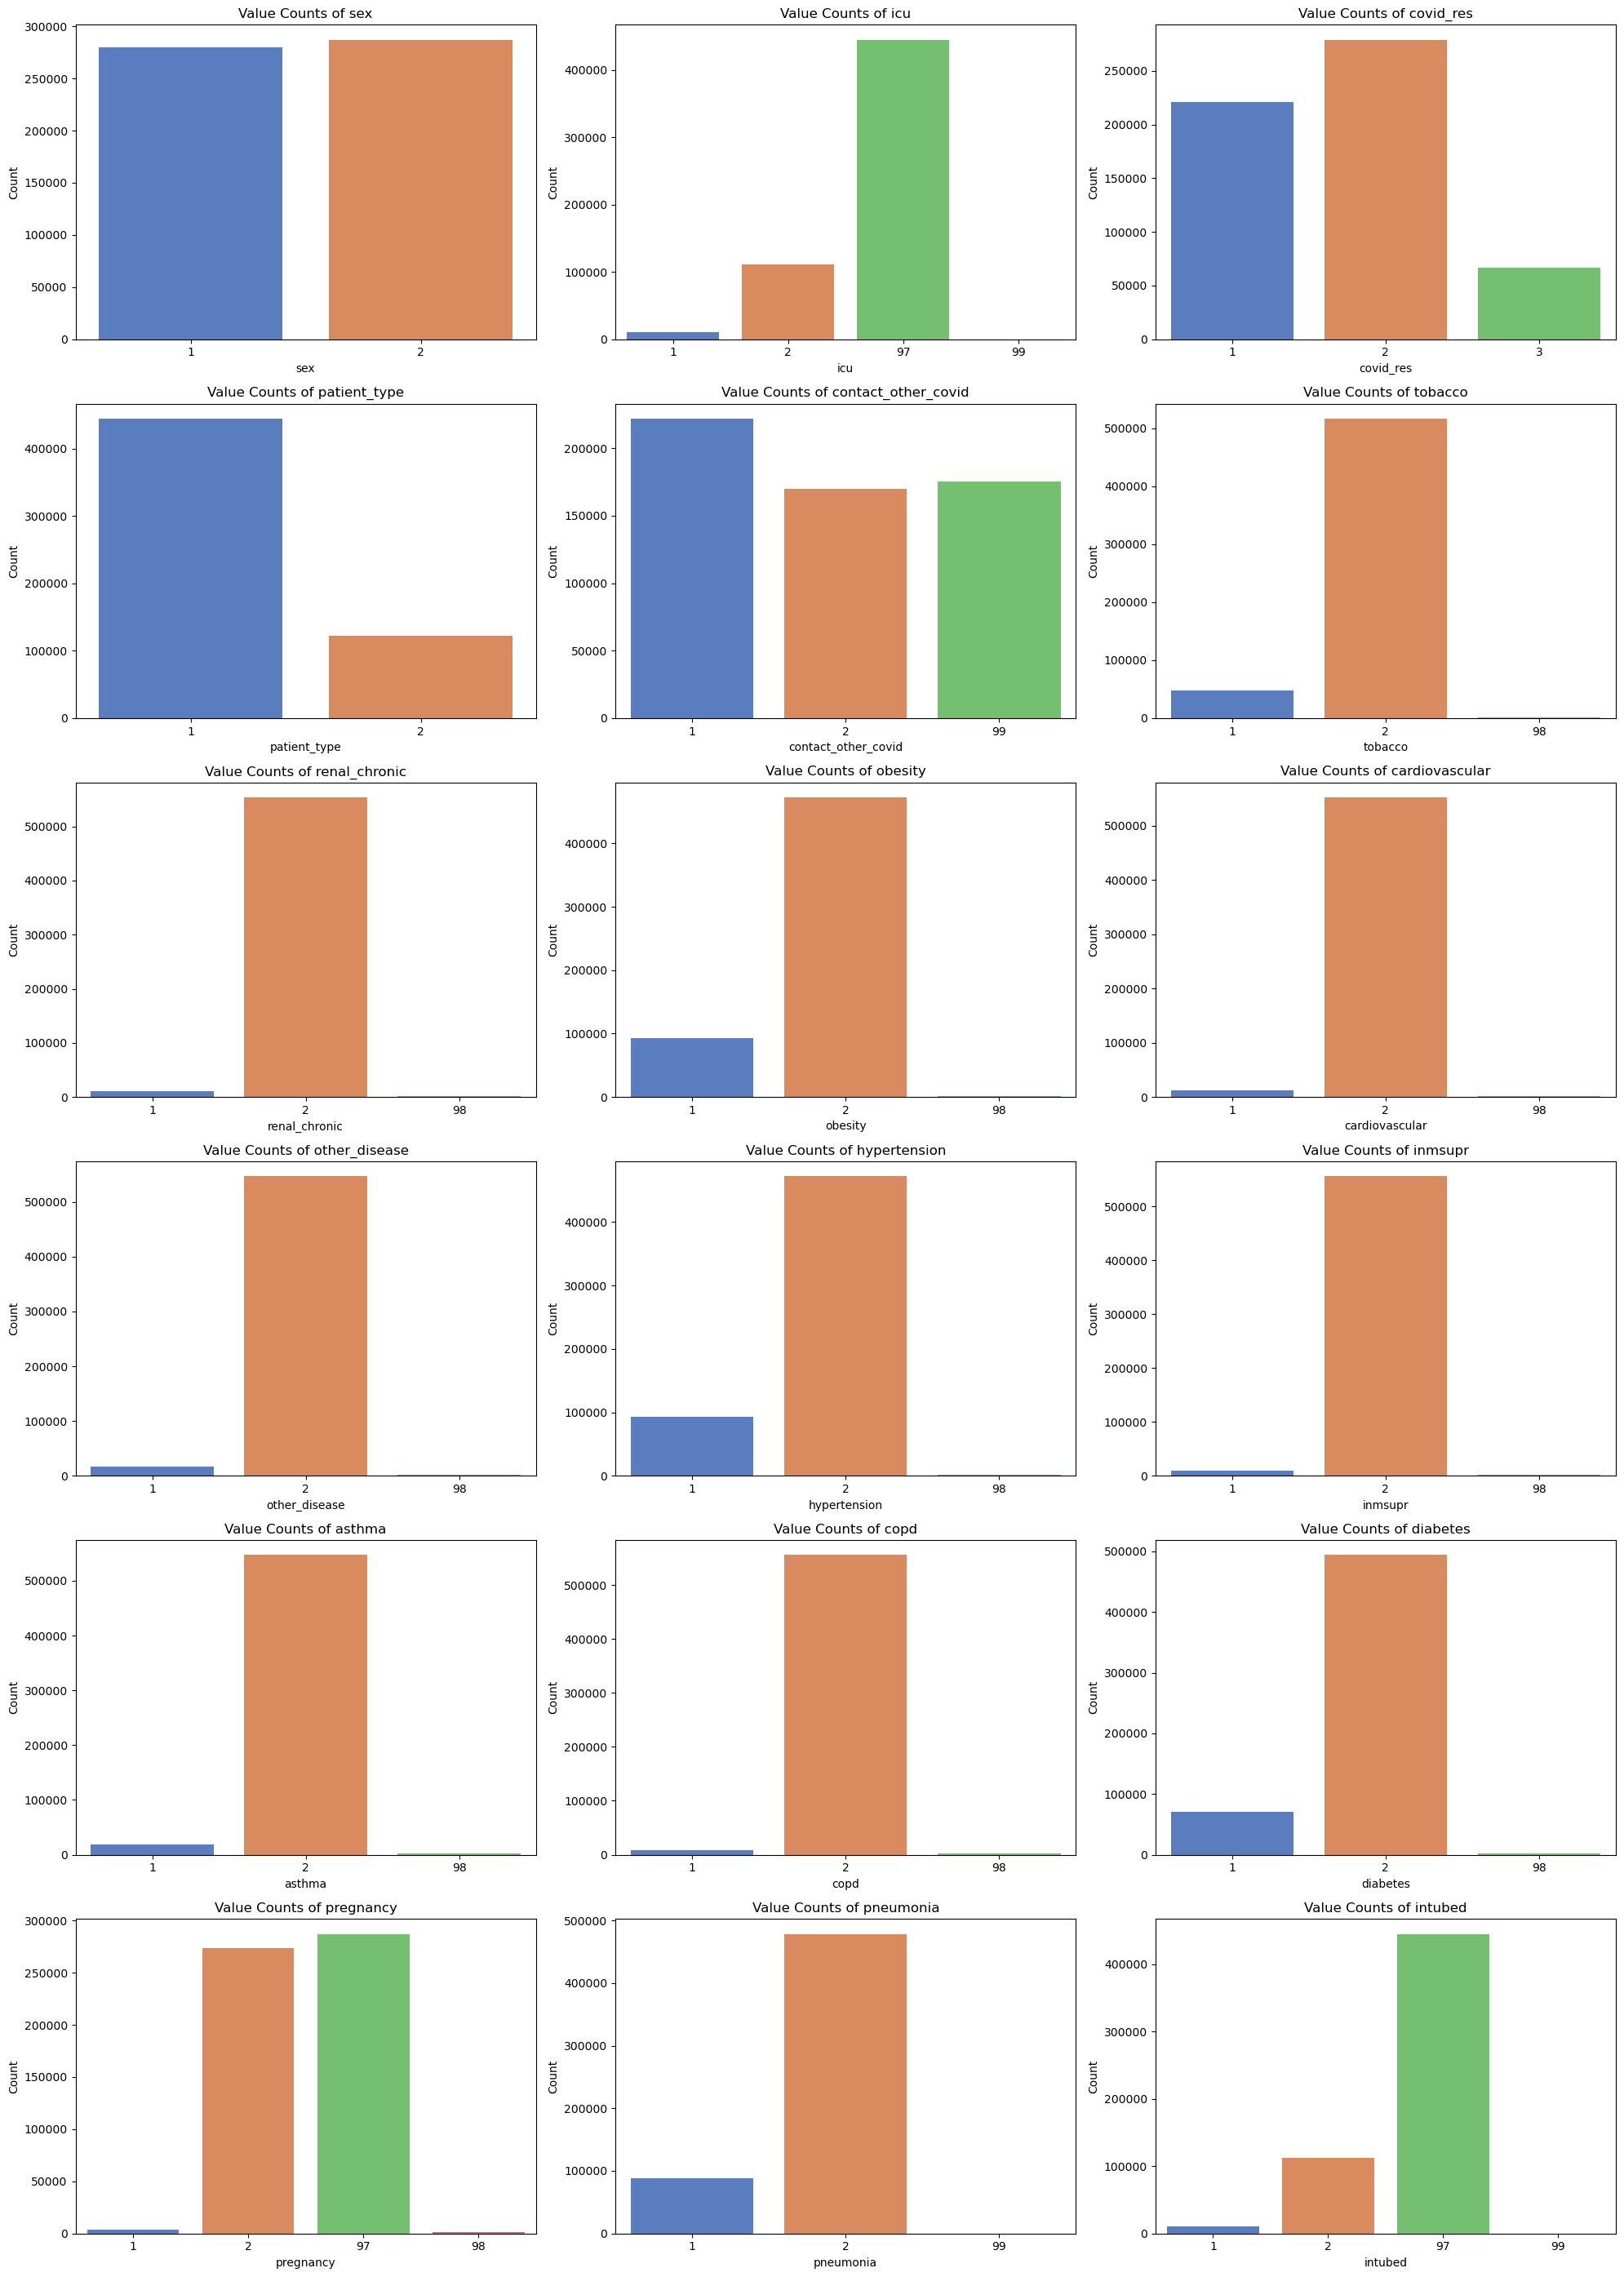

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_plot = ['sex', 'icu', 'covid_res', 'patient_type', 'contact_other_covid', 'tobacco', 'renal_chronic', 'obesity', 'cardiovascular', 'other_disease', 'hypertension', 'inmsupr', 'asthma', 'copd', 'diabetes', 'pregnancy', 'pneumonia', 'intubed']

fig, axes = plt.subplots(6, 3, figsize=(20, 28))

# 각 칼럼의 값 분포 시각화
for i, column in enumerate(columns_to_plot):
    row = i // 3  
    col = i % 3   
    
    value_counts = co_df[column].value_counts()
    
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[row, col], palette='muted')
    axes[row, col].set_title(f'Value Counts of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [6]:
co_df['age'].max()

120

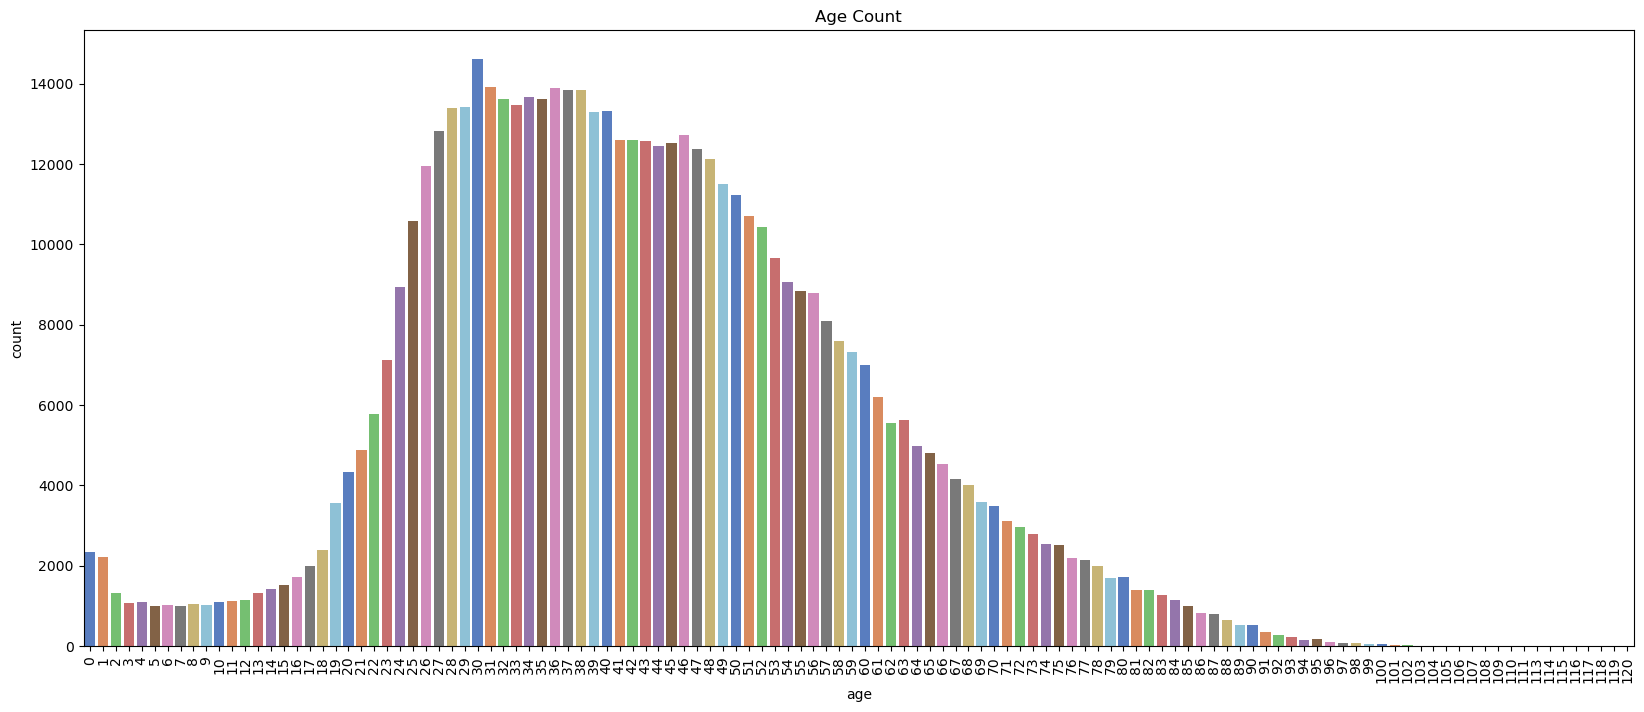

In [7]:
age_df = co_df[['age']]
plt.figure(figsize=(20, 8))
sns.countplot(x='age', data=age_df, palette='muted')
plt.title('Age Count')
plt.xticks(rotation=90)
plt.show()

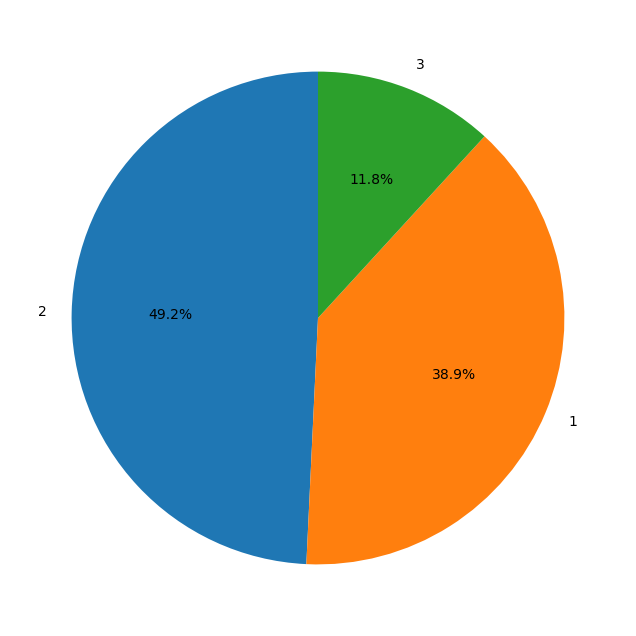

covid_res
2    279035
1    220657
3     66910
Name: count, dtype: int64

In [8]:
covid_res = co_df['covid_res'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(covid_res, labels=covid_res.index, autopct='%1.1f%%', startangle=90)
plt.show()
covid_res
# 워낙 데이터수가 많다보니 결측치의 값이 10프로가 넘어갔는데도 과감하게 제거하기로 결정

# 데이터 전처리

In [9]:
# 질병이 아닌 칼럼들은 삭제했다.
co_df = co_df.drop(columns=['icu', 'sex', 'patient_type', 'intubed', 'id', 'entry_date', 'pregnancy', 'date_symptoms', 'date_died', 'contact_other_covid'], axis=1)
co_df

pneumonia  age  diabetes  copd  asthma  inmsupr  hypertension  \
0               2   27         2     2       2        2             2   
1               2   24         2     2       2        2             2   
2               2   54         2     2       2        2             2   
3               1   30         2     2       2        2             2   
4               2   60         1     2       2        2             1   
...           ...  ...       ...   ...     ...      ...           ...   
566597          2   58         1     2       2        2             2   
566598          2   48         2     2       2        2             2   
566599          1   49         2     2       2        2             2   
566600          1   43         2     2       2        2             2   
566601          1   65         1     2       2        2             1   

        other_disease  cardiovascular  obesity  renal_chronic  tobacco  \
0                   2               2        2              2        2   
1                   2               2        2              2        2   
2                   2               2        1              2        2   
3                   2               2        2              2        2   
4                   2               1        2              2        2   
...               ...             ...      ...            ...      ...   
566597              2               2        2              2        2   
566598              2               2        2              2        2   
566599              2               2        1              2        2   
566600              2               2        2              2        2   
566601              2               2        1              2        2   

        covid_res  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
566597          3  
566598          3  
566599          3  
566600          3  
566601          3  

[566602 rows x 13 columns]

In [10]:
# 결측치를 모두 제거했다.
# 피쳐들은 질병들로 이루어져있다. 여기서 결측치를 질병있다고 대체할 경우 질병에 대한 코로나 감염유무에 대한 판단이 흐려질 것이라고 판단했다.
co_df = co_df[co_df['tobacco'] != 98]
co_df = co_df[co_df['diabetes'] != 98]
co_df = co_df[co_df['copd'] != 98]
co_df = co_df[co_df['asthma'] != 98]
co_df = co_df[co_df['inmsupr'] != 98]
co_df = co_df[co_df['hypertension'] != 98]
co_df = co_df[co_df['other_disease'] != 98]
co_df = co_df[co_df['cardiovascular'] != 98]
co_df = co_df[co_df['obesity'] != 98]
co_df = co_df[co_df['renal_chronic'] != 98]
co_df = co_df[co_df['pneumonia'] != 99]
co_df = co_df[co_df['covid_res'] != 3]

In [11]:
co_df = co_df.reset_index()
co_df = co_df.drop(columns=['index'], axis=1)
co_df

pneumonia  age  diabetes  copd  asthma  inmsupr  hypertension  \
0               2   27         2     2       2        2             2   
1               2   24         2     2       2        2             2   
2               2   54         2     2       2        2             2   
3               1   30         2     2       2        2             2   
4               2   60         1     2       2        2             1   
...           ...  ...       ...   ...     ...      ...           ...   
496286          1   77         2     2       2        2             2   
496287          1   63         2     2       2        2             1   
496288          2   25         2     2       2        2             2   
496289          2   45         2     2       2        2             1   
496290          2   51         2     2       2        2             2   

        other_disease  cardiovascular  obesity  renal_chronic  tobacco  \
0                   2               2        2              2        2   
1                   2               2        2              2        2   
2                   2               2        1              2        2   
3                   2               2        2              2        2   
4                   2               1        2              2        2   
...               ...             ...      ...            ...      ...   
496286              1               2        2              2        1   
496287              2               2        1              2        1   
496288              2               2        2              2        2   
496289              2               2        2              2        2   
496290              2               2        2              2        2   

        covid_res  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
496286          2  
496287          2  
496288          2  
496289          2  
496290          2  

[496291 rows x 13 columns]

# 전처리 후 재확인 시각화

['covid_res', 'tobacco', 'renal_chronic', 'obesity', 'other_disease', 'inmsupr', 'asthma', 'copd', 'diabetes', 'pneumonia', 'cardiovascular', 'hypertension']


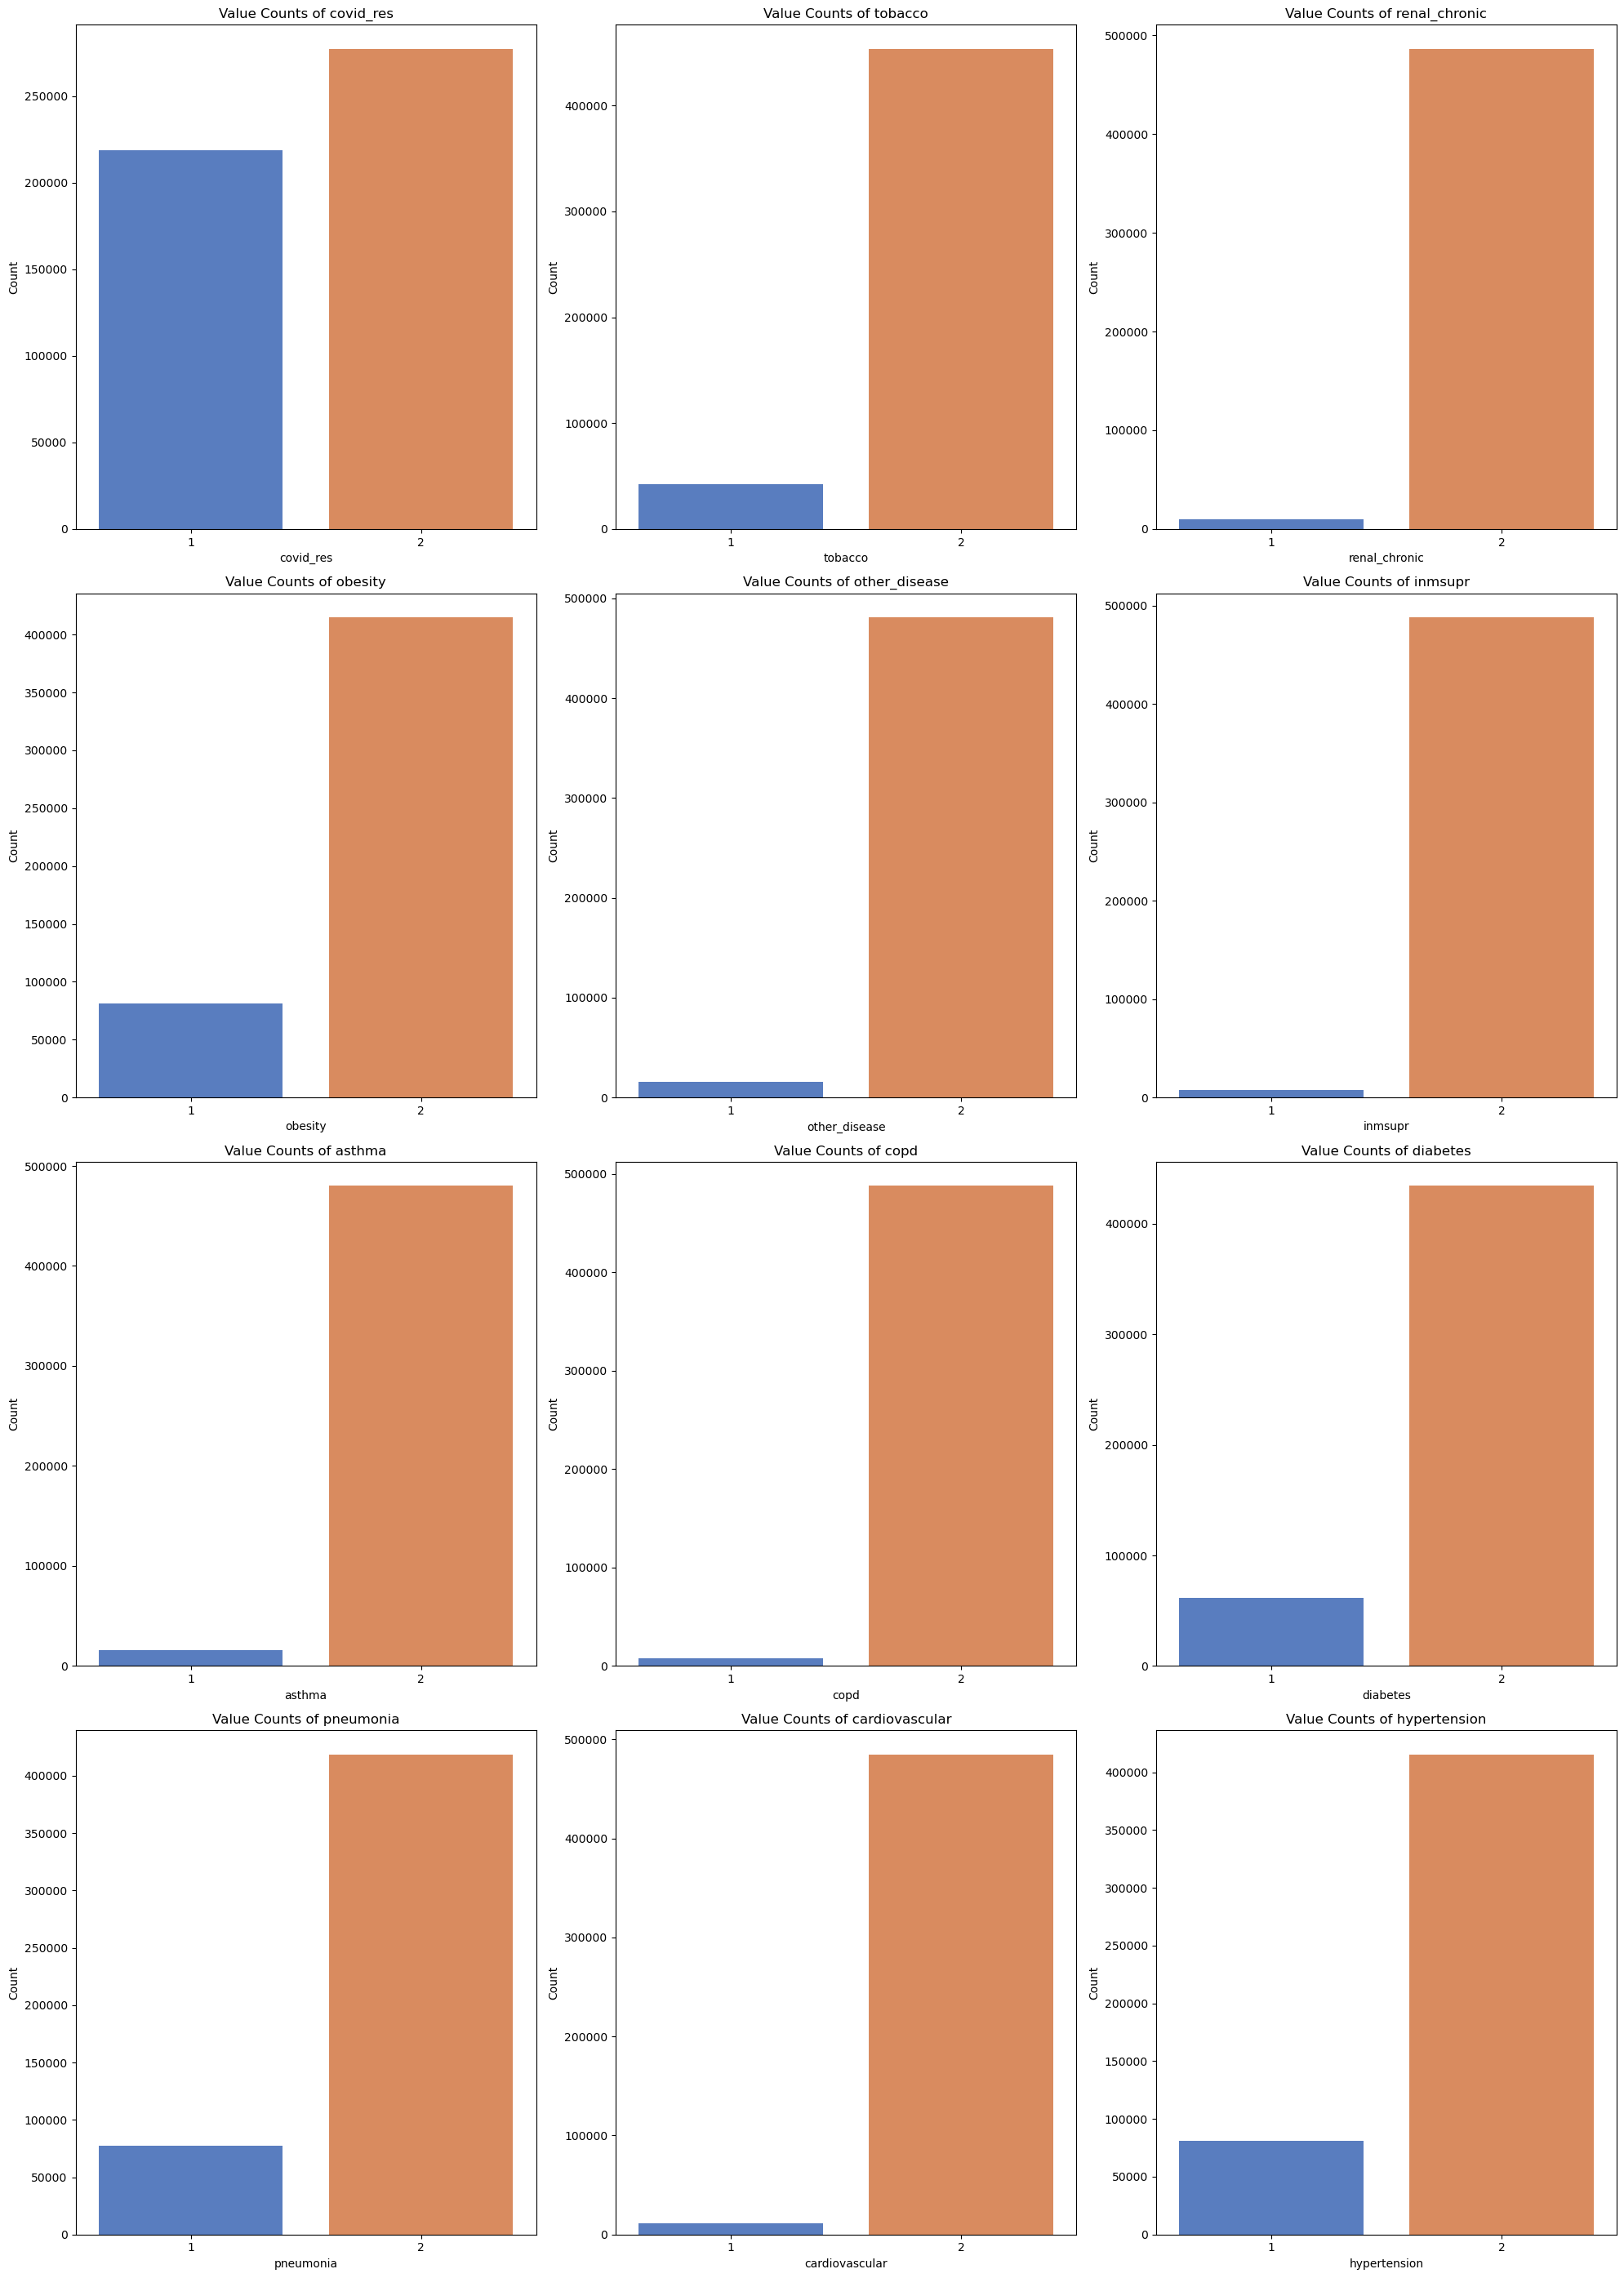

In [12]:
columns_to_plot = ['covid_res', 'tobacco', 'renal_chronic', 'obesity',  'other_disease', 'inmsupr', 'asthma', 'copd', 'diabetes', 'pneumonia', 'cardiovascular', 'hypertension']
# columns_to_plot = co_df.columns.tolist()
print(columns_to_plot)
fig, axes = plt.subplots(4, 3, figsize=(20, 28))
for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3   

    data = co_df[column].value_counts()
    sns.barplot(x=data.index, y=data, ax=axes[row, col], palette='muted')
    axes[row, col].set_title(f'Value Counts of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')
plt.tight_layout()
plt.show()

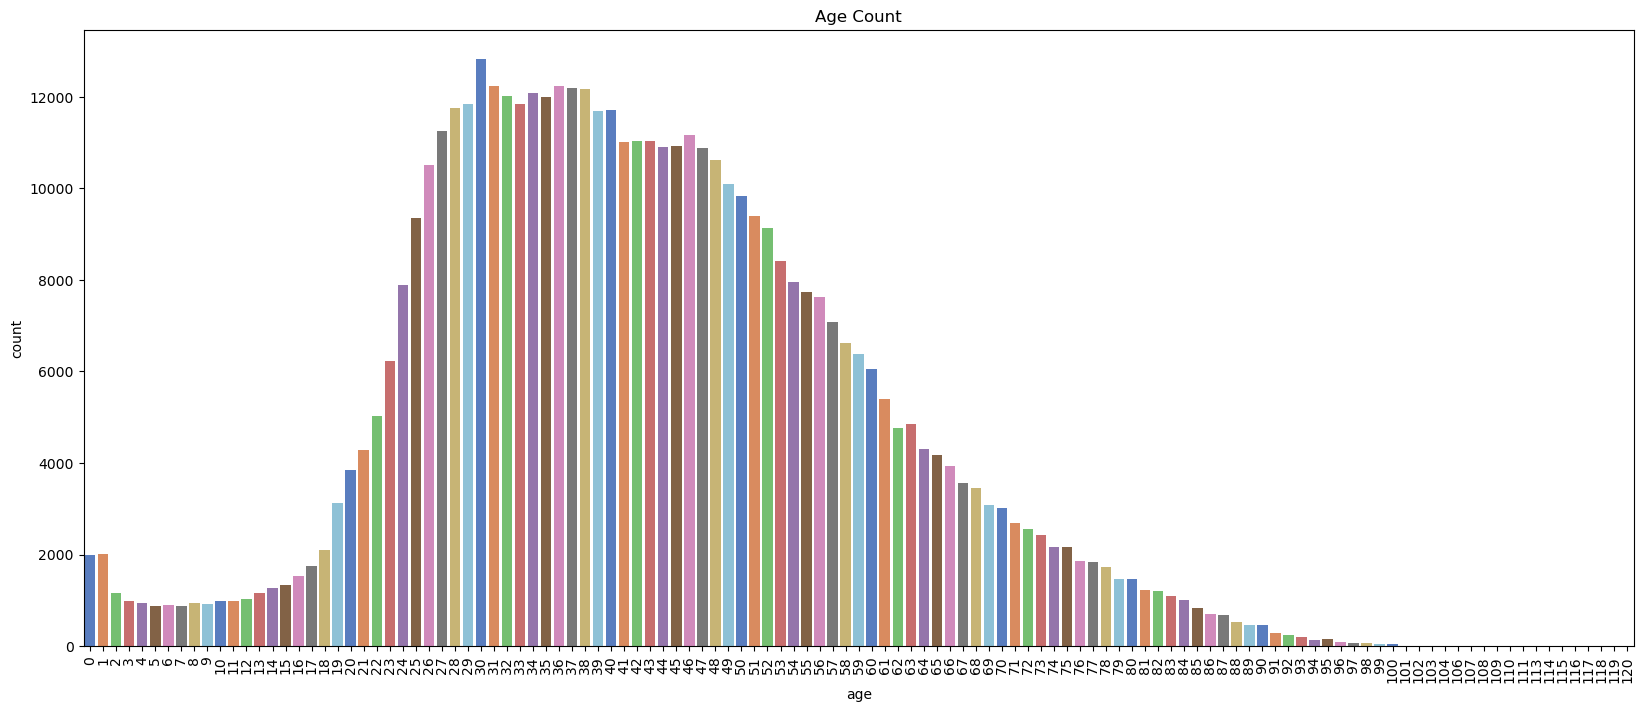

In [13]:
age_df = co_df[['age']]
plt.figure(figsize=(20, 8))
sns.countplot(x='age', data=age_df, palette='muted')
plt.title('Age Count')
plt.xticks(rotation=90)
plt.show()

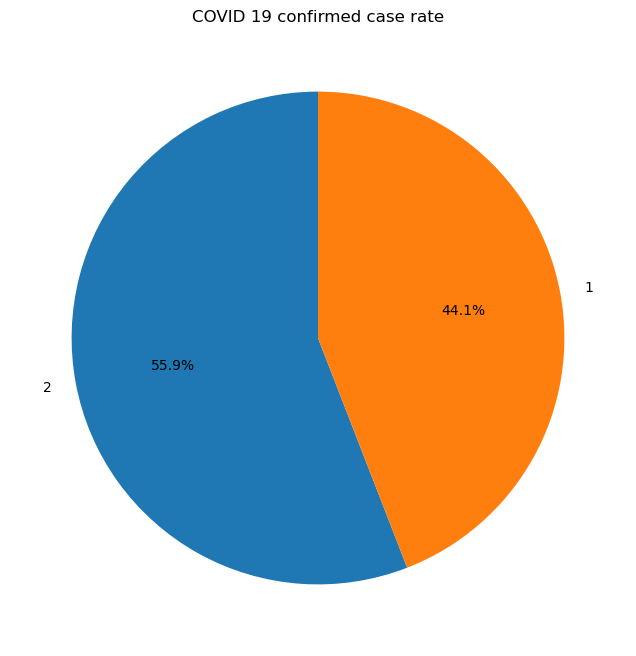

covid_res
2    277389
1    218902
Name: count, dtype: int64

In [14]:
covid_res = co_df['covid_res'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(covid_res, labels=covid_res.index, autopct='%1.1f%%', startangle=90)
plt.title('COVID 19 confirmed case rate')
plt.show()
covid_res

# 데이터 세트 분리  

In [15]:
columns_to_convert = co_df.columns.difference(['age']) 
co_df[columns_to_convert] = co_df[columns_to_convert].replace(2, 0)
co_df

pneumonia  age  diabetes  copd  asthma  inmsupr  hypertension  \
0               0   27         0     0       0        0             0   
1               0   24         0     0       0        0             0   
2               0   54         0     0       0        0             0   
3               1   30         0     0       0        0             0   
4               0   60         1     0       0        0             1   
...           ...  ...       ...   ...     ...      ...           ...   
496286          1   77         0     0       0        0             0   
496287          1   63         0     0       0        0             1   
496288          0   25         0     0       0        0             0   
496289          0   45         0     0       0        0             1   
496290          0   51         0     0       0        0             0   

        other_disease  cardiovascular  obesity  renal_chronic  tobacco  \
0                   0               0        0              0        0   
1                   0               0        0              0        0   
2                   0               0        1              0        0   
3                   0               0        0              0        0   
4                   0               1        0              0        0   
...               ...             ...      ...            ...      ...   
496286              1               0        0              0        1   
496287              0               0        1              0        1   
496288              0               0        0              0        0   
496289              0               0        0              0        0   
496290              0               0        0              0        0   

        covid_res  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
496286          0  
496287          0  
496288          0  
496289          0  
496290          0  

[496291 rows x 13 columns]

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

features = co_df.iloc[:, :-1]
targets = co_df.iloc[:, -1]
display(features)
display(targets)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.25, random_state=124, stratify=targets)

pneumonia  age  diabetes  copd  asthma  inmsupr  hypertension  \
0               0   27         0     0       0        0             0   
1               0   24         0     0       0        0             0   
2               0   54         0     0       0        0             0   
3               1   30         0     0       0        0             0   
4               0   60         1     0       0        0             1   
...           ...  ...       ...   ...     ...      ...           ...   
496286          1   77         0     0       0        0             0   
496287          1   63         0     0       0        0             1   
496288          0   25         0     0       0        0             0   
496289          0   45         0     0       0        0             1   
496290          0   51         0     0       0        0             0   

        other_disease  cardiovascular  obesity  renal_chronic  tobacco  
0                   0               0        0              0        0  
1                   0               0        0              0        0  
2                   0               0        1              0        0  
3                   0               0        0              0        0  
4                   0               1        0              0        0  
...               ...             ...      ...            ...      ...  
496286              1               0        0              0        1  
496287              0               0        1              0        1  
496288              0               0        0              0        0  
496289              0               0        0              0        0  
496290              0               0        0              0        0  

[496291 rows x 12 columns]

0         1
1         1
2         1
3         1
4         1
         ..
496286    0
496287    0
496288    0
496289    0
496290    0
Name: covid_res, Length: 496291, dtype: int64

In [17]:
dtc = DecisionTreeClassifier()

# 교차 검증

In [18]:
# 하이퍼파라미터를 임의로 설정
parameters = {'max_depth': [4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [4, 5, 6, 7, 8, 9, 10]}
g_dtc = GridSearchCV(dtc, param_grid=parameters, cv=5, refit=True, return_train_score=True)

# 훈련 시작

In [19]:
g_dtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [20]:
g_dtc.cv_results_

{'mean_fit_time': array([0.2740685 , 0.26967626, 0.27486901, 0.30737038, 0.27727413,
        0.26688752, 0.27484589, 0.33292646, 0.3273387 , 0.30359445,
        0.30659809, 0.30998178, 0.30857177, 0.31103811, 0.37738409,
        0.37718472, 0.36383591, 0.31814413, 0.38677521, 0.30458565,
        0.30956154, 0.34786253, 0.43245044, 0.3674243 , 0.39314895,
        0.38516259, 0.36324492, 0.36124759, 0.45120397, 0.40371666,
        0.42645707, 0.40729265, 0.40591159, 0.40032597, 0.42325363,
        0.44860997, 0.44063044, 0.42784586, 0.50465937, 0.56310468,
        0.45956011, 0.49388008, 0.46414747, 0.49209099, 0.47453737,
        0.49545379, 0.47593641, 0.48212914, 0.47494426]),
 'std_fit_time': array([0.01387532, 0.03315417, 0.01657806, 0.05925388, 0.01154716,
        0.01704045, 0.0388853 , 0.03962233, 0.01507686, 0.01339515,
        0.02219585, 0.02352831, 0.01512427, 0.024579  , 0.05012275,
        0.01798481, 0.01366046, 0.02650158, 0.07828956, 0.00990449,
        0.01484136, 0.017

In [21]:
# 보고싶은 칼럼들만 출력
result_df = pd.DataFrame(g_dtc.cv_results_)[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score', 'split2_test_score']]
result_df

params  mean_test_score  \
0     {'max_depth': 4, 'min_samples_split': 4}         0.618302   
1     {'max_depth': 4, 'min_samples_split': 5}         0.618302   
2     {'max_depth': 4, 'min_samples_split': 6}         0.618302   
3     {'max_depth': 4, 'min_samples_split': 7}         0.618302   
4     {'max_depth': 4, 'min_samples_split': 8}         0.618302   
5     {'max_depth': 4, 'min_samples_split': 9}         0.618302   
6    {'max_depth': 4, 'min_samples_split': 10}         0.618302   
7     {'max_depth': 5, 'min_samples_split': 4}         0.619881   
8     {'max_depth': 5, 'min_samples_split': 5}         0.619881   
9     {'max_depth': 5, 'min_samples_split': 6}         0.619881   
10    {'max_depth': 5, 'min_samples_split': 7}         0.619881   
11    {'max_depth': 5, 'min_samples_split': 8}         0.619881   
12    {'max_depth': 5, 'min_samples_split': 9}         0.619881   
13   {'max_depth': 5, 'min_samples_split': 10}         0.619881   
14    {'max_depth': 6, 'min_samples_split': 4}         0.620397   
15    {'max_depth': 6, 'min_samples_split': 5}         0.620403   
16    {'max_depth': 6, 'min_samples_split': 6}         0.620403   
17    {'max_depth': 6, 'min_samples_split': 7}         0.620403   
18    {'max_depth': 6, 'min_samples_split': 8}         0.620403   
19    {'max_depth': 6, 'min_samples_split': 9}         0.620403   
20   {'max_depth': 6, 'min_samples_split': 10}         0.620403   
21    {'max_depth': 7, 'min_samples_split': 4}         0.620806   
22    {'max_depth': 7, 'min_samples_split': 5}         0.620797   
23    {'max_depth': 7, 'min_samples_split': 6}         0.620806   
24    {'max_depth': 7, 'min_samples_split': 7}         0.620806   
25    {'max_depth': 7, 'min_samples_split': 8}         0.620797   
26    {'max_depth': 7, 'min_samples_split': 9}         0.620800   
27   {'max_depth': 7, 'min_samples_split': 10}         0.620806   
28    {'max_depth': 8, 'min_samples_split': 4}         0.621131   
29    {'max_depth': 8, 'min_samples_split': 5}         0.621139   
30    {'max_depth': 8, 'min_samples_split': 6}         0.621133   
31    {'max_depth': 8, 'min_samples_split': 7}         0.621123   
32    {'max_depth': 8, 'min_samples_split': 8}         0.621133   
33    {'max_depth': 8, 'min_samples_split': 9}         0.621136   
34   {'max_depth': 8, 'min_samples_split': 10}         0.621147   
35    {'max_depth': 9, 'min_samples_split': 4}         0.620655   
36    {'max_depth': 9, 'min_samples_split': 5}         0.620663   
37    {'max_depth': 9, 'min_samples_split': 6}         0.620650   
38    {'max_depth': 9, 'min_samples_split': 7}         0.620669   
39    {'max_depth': 9, 'min_samples_split': 8}         0.620647   
40    {'max_depth': 9, 'min_samples_split': 9}         0.620639   
41   {'max_depth': 9, 'min_samples_split': 10}         0.620652   
42   {'max_depth': 10, 'min_samples_split': 4}         0.620526   
43   {'max_depth': 10, 'min_samples_split': 5}         0.620526   
44   {'max_depth': 10, 'min_samples_split': 6}         0.620523   
45   {'max_depth': 10, 'min_samples_split': 7}         0.620529   
46   {'max_depth': 10, 'min_samples_split': 8}         0.620537   
47   {'max_depth': 10, 'min_samples_split': 9}         0.620507   
48  {'max_depth': 10, 'min_samples_split': 10}         0.620523   

    rank_test_score  split0_test_score  split1_test_score  split2_test_score  
0                43           0.619566           0.617310           0.618545  
1                43           0.619566           0.617310           0.618545  
2                43           0.619566           0.617310           0.618545  
3                43           0.619566           0.617310           0.618545  
4                43           0.619566           0.617310           0.618545  
5                43           0.619566           0.617310           0.618545  
6                43           0.619566           0.617310           0.618545  
7                36           0.620963           0.618707

In [22]:
print(g_dtc.best_params_, g_dtc.best_score_, sep="\n")

{'max_depth': 8, 'min_samples_split': 10}
0.6211467456019888


In [23]:
dtc = g_dtc.best_estimator_

# graphviz로 결정트리 시각화

In [24]:
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score

In [25]:
target_labels = targets.unique().astype(str)

export_graphviz(
    dtc, 
    out_file='./images/covid_dtc.dot',
    class_names=target_labels,
    feature_names=features.columns,
    impurity=True,  
    filled=True  
)

In [26]:
import graphviz

with open('./images/covid_dtc.dot') as f:
    covid_dtc = f.read()

covid_dtc_graph = graphviz.Source(covid_dtc)

In [27]:
covid_dtc_graph.render(filename="covid_dtc", directory="./images", format="png", engine="dot")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.874883 to fit


'images\\covid_dtc.png'

<img src="./images/covid_dtc.png">

# 타겟별 각 피쳐 비중 시각화

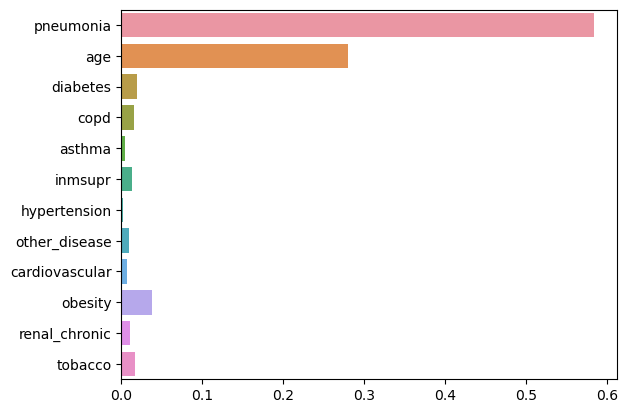

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=dtc.feature_importances_, y=features.columns)
plt.show()

# 산점도로 비중 높은 피쳐들 확인

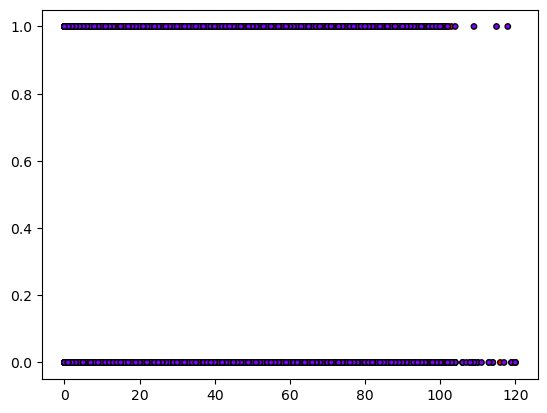

In [29]:
plt.scatter(co_df['age'], co_df['pneumonia'], c=targets, edgecolors='k', cmap="rainbow", s=15, marker='o')
plt.show()

In [30]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=15, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X.values, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow',
                           zorder=1)

# 과적합 확인

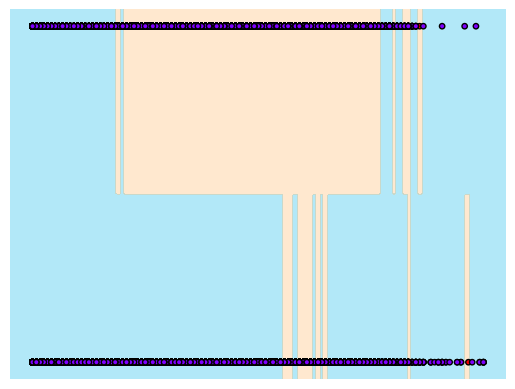

In [31]:
scatter_features = co_df[['age', 'pneumonia']] 
dtc = DecisionTreeClassifier(random_state=124)
visualize_boundary(dtc, scatter_features, targets)

# 테스트 및 정확도 확인

In [32]:
dtc = g_dtc.best_estimator_
prediction = dtc.predict(X_test)
accuracy_score(y_test, prediction)

0.6223352381259419

In [33]:
co_df

pneumonia  age  diabetes  copd  asthma  inmsupr  hypertension  \
0               0   27         0     0       0        0             0   
1               0   24         0     0       0        0             0   
2               0   54         0     0       0        0             0   
3               1   30         0     0       0        0             0   
4               0   60         1     0       0        0             1   
...           ...  ...       ...   ...     ...      ...           ...   
496286          1   77         0     0       0        0             0   
496287          1   63         0     0       0        0             1   
496288          0   25         0     0       0        0             0   
496289          0   45         0     0       0        0             1   
496290          0   51         0     0       0        0             0   

        other_disease  cardiovascular  obesity  renal_chronic  tobacco  \
0                   0               0        0              0        0   
1                   0               0        0              0        0   
2                   0               0        1              0        0   
3                   0               0        0              0        0   
4                   0               1        0              0        0   
...               ...             ...      ...            ...      ...   
496286              1               0        0              0        1   
496287              0               0        1              0        1   
496288              0               0        0              0        0   
496289              0               0        0              0        0   
496290              0               0        0              0        0   

        covid_res  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
496286          0  
496287          0  
496288          0  
496289          0  
496290          0  

[496291 rows x 13 columns]

# 평가 지표 확인

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 타겟 데이터와 예측 객체를 전달받는다.
def get_evaluation_by_custom_proba(y_test, prediction, visualize=False):
# 오차 행렬
    confusion = confusion_matrix(y_test, prediction)
# 정확도
    accuracy = accuracy_score(y_test , prediction)
# 정밀도
    precision = precision_score(y_test , prediction)
# 재현율
    recall = recall_score(y_test , prediction)
# F1 score
    f1 = f1_score(y_test, prediction)
# ROC-AUC
    roc_auc = roc_auc_score(y_test, prediction)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, ROC-AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 80)
    
    if visualize:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]
        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_predictions(y_test, prediction, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[60538  8809]
 [38049 16677]]
정확도: 0.6223, 정밀도: 0.6544, 재현율: 0.3047, F1: 0.4158, ROC-AUC: 0.5889
################################################################################


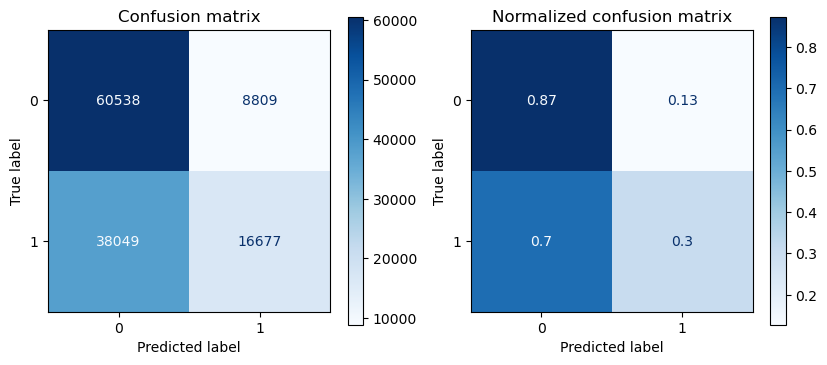

In [35]:
# 히트맵으로 평가 지표 확인
get_evaluation_by_custom_proba(y_test, prediction, visualize=True)

- F1 스코어가 너무 낮다.

In [36]:
# 예측 결과를 확인
proba = dtc.predict_proba(X_test)
prediction = dtc.predict(X_test)

for proba, predict in zip(proba.tolist(), prediction.tolist()):
    print(proba, predict)

[0.45656582727733647, 0.5434341727226635] 1
[0.6652412769116556, 0.3347587230883445] 0
[0.6951207491375062, 0.30487925086249384] 0
[0.5253218884120172, 0.47467811158798284] 0
[0.5045261669024045, 0.49547383309759546] 0
[0.3798609322688643, 0.6201390677311357] 1
[0.638787424682339, 0.361212575317661] 0
[0.24757798215211638, 0.7524220178478837] 1
[0.638787424682339, 0.361212575317661] 0
[0.7756302521008404, 0.22436974789915967] 0
[0.24757798215211638, 0.7524220178478837] 1
[0.5153070358656084, 0.4846929641343916] 0
[0.6652412769116556, 0.3347587230883445] 0
[0.5153070358656084, 0.4846929641343916] 0
[0.5722353277575237, 0.4277646722424762] 0
[0.6652412769116556, 0.3347587230883445] 0
[0.61302383812408, 0.38697616187591993] 0
[0.45656582727733647, 0.5434341727226635] 1
[0.5348307291666666, 0.4651692708333333] 0
[0.6652412769116556, 0.3347587230883445] 0
[0.5253218884120172, 0.47467811158798284] 0
[0.8158624514697727, 0.1841375485302274] 0
[0.5722353277575237, 0.4277646722424762] 0
[0.6387

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [37]:
from sklearn.preprocessing import Binarizer
# 임계치 0.5로 위에서 츨력한 오차행렬 수치들과 같은지 확인
# 임계치를 수정후에 수정전이랑 비교하기 위해 roc 시각화
threshold = 0.5

proba = dtc.predict_proba(X_test)
prediction = dtc.predict(X_test)

In [38]:
custom_proba = proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=threshold).fit(custom_proba)
custom_prediction = binarizer.transform(custom_proba)

get_evaluation_by_custom_proba(y_test, custom_prediction)

오차 행렬
[[60538  8809]
 [38049 16677]]
정확도: 0.6223, 정밀도: 0.6544, 재현율: 0.3047, F1: 0.4158, ROC-AUC: 0.5889
################################################################################


In [39]:
def get_evaluation_by_thresholds(y_test, proba_class1, thresholds):
    for threshold in thresholds:
        print(threshold)
        binarizer = Binarizer(threshold=threshold).fit(proba_class1)
        custom_prediction = binarizer.transform(proba_class1)
        get_evaluation_by_custom_proba(y_test, custom_prediction)

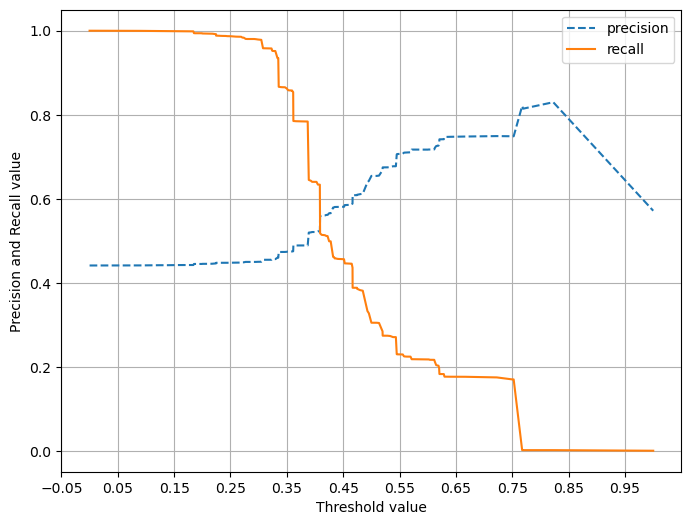

In [40]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test , proba_class1):

    precisions, recalls, thresholds = precision_recall_curve(y_test, proba_class1)
    
    # X축: threshold
    # Y축: 정밀도, 재현율 
    # 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # X축(threshold)의 Scale을 0 ~ 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, dtc.predict_proba(X_test)[:, 1].reshape(-1, 1))

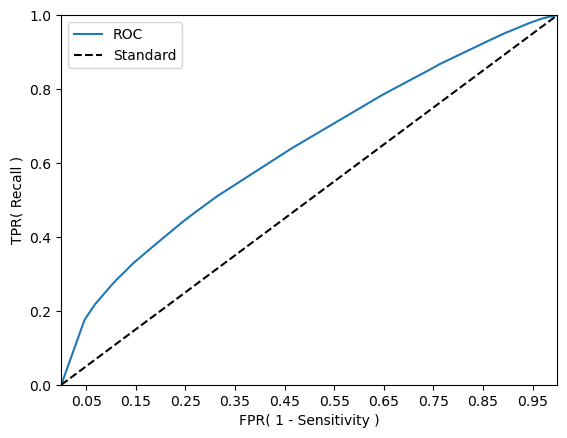

In [41]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test , proba_class1):
#     임계값에 따른 FPR, TPR 값
    fprs, tprs, thresholds = roc_curve(y_test, proba_class1)

#     ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
#     가운데 대각선 직선을 그림. 
#     TPR과 FPR이 동일한 비율로 떨어진다는 것은 모델이 양성과 음성을 구별하지 못한다는 것을 의미한다.
#     다른 분류기를 판단하기 위한 기준선으로 사용되며, 
#     대각선에 가까울 수록 예측에 사용하기 힘든 모델이라는 뜻이다.
    plt.plot([0, 1], [0, 1], 'k--', label='Standard')
    
    # X축(FPR)의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, dtc.predict_proba(X_test)[:, 1].reshape(-1, 1))

# 환자 건강상태에 따른 코로나 감염 유무를 판단해야 하는 시나리오.

- Positive: 환자가 코로나에 감염되었다
- Negative: 환자가 코로나에 감염되지 않았다
  
> - TP 모델이 감염 환자를 감염으로 올바르게 분류
> - FP 모델이 비감염 환자를 감염 환자로 잘못 분류(error I)
> - TN 모델이 비감염 환자를 감염 환자로 올바르게 분류
> - FN 모델이 감염 환자를 비감염 환자로 잘못 분류(error II)

## 결론
    해당 시나리오에서는 감염된 환자를 감염되지 않은 환자로 잘못분류하는 것이 훨씬 더 위험하다
    코로나는 전염성이 강하므로 감염된 환자는 비감염자에게 전염을 시키지 못하게 막아야 하기 때문이다.
    하지만 이를 감지하지 못하고 감염된 환자가 다시 사회로 돌아가게 되면 더 많은 코로나 감염자가 생길수 있어 사회 전체에 큰 타격을 줄것이다.

- 정밀도: 모델이 감염으로 예측한 환자중에서 실제로 감염인 환자의 비율을 나타낸다.
- 재현율: 실제 감염 환자 중에서 모델이 감염으로 정확하게 예측한 환자의 비율을 나타낸다.

### 이는 재현율를 올려야하며 임계치를 낮추어서 재현율을 높이고 정밀도를 낮추어야 한다.

In [42]:
# max_depth 확인 (과적합)
print(dtc.max_depth)  
# min_samples_split 확인
print(dtc.min_samples_split)  

8
10


In [43]:
features, targets = co_df.iloc[:, :-1], co_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=124)

dtc = DecisionTreeClassifier()
parameters = {'max_depth': [4, 5, 6, 7, 8, 9, 10, 11], 'min_samples_split': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}

g_dtc = GridSearchCV(dtc, param_grid=parameters, cv=5, refit=True, return_train_score=True)

g_dtc.fit(X_train, y_train)

pd.DataFrame(g_dtc.cv_results_)[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

params  mean_test_score  \
0     {'max_depth': 4, 'min_samples_split': 4}         0.618764   
1     {'max_depth': 4, 'min_samples_split': 5}         0.618764   
2     {'max_depth': 4, 'min_samples_split': 6}         0.618764   
3     {'max_depth': 4, 'min_samples_split': 7}         0.618764   
4     {'max_depth': 4, 'min_samples_split': 8}         0.618764   
..                                         ...              ...   
75   {'max_depth': 11, 'min_samples_split': 9}         0.620444   
76  {'max_depth': 11, 'min_samples_split': 10}         0.620449   
77  {'max_depth': 11, 'min_samples_split': 11}         0.620446   
78  {'max_depth': 11, 'min_samples_split': 12}         0.620451   
79  {'max_depth': 11, 'min_samples_split': 13}         0.620476   

    rank_test_score  split0_test_score  split1_test_score  split2_test_score  
0                71           0.618346           0.618195           0.620243  
1                71           0.618346           0.618195           0.620243  
2                71           0.618346           0.618195           0.620243  
3                71           0.618346           0.618195           0.620243  
4                71           0.618346           0.618195           0.620243  
..              ...                ...                ...                ...  
75               67           0.620915           0.620474           0.621162  
76               55           0.621003           0.620499           0.621124  
77               66           0.620978           0.620449           0.621150  
78               53           0.620965           0.620499           0.621162  
79               51           0.621079           0.620487           0.621162  

[80 rows x 6 columns]

In [44]:
from sklearn.metrics import accuracy_score

dtc = g_dtc.best_estimator_
prediction = dtc.predict(X_test)

print(f'정확도: {np.round(accuracy_score(y_test, prediction) * 100, 4)}%')

정확도: 62.2956%


In [45]:
# 임계치값들을 확인하기
proba_class1 = dtc.predict_proba(X_test)[:, 1].reshape(-1, 1)
_, _, thresholds = precision_recall_curve(y_test, proba_class1)
thresholds

array([0.        , 0.02702703, 0.05263158, 0.06818182, 0.07142857,
       0.07272727, 0.07407407, 0.07692308, 0.08333333, 0.09090909,
       0.09191176, 0.11111111, 0.11538462, 0.11764706, 0.125     ,
       0.13253012, 0.13333333, 0.14285714, 0.15789474, 0.16      ,
       0.17391304, 0.17757009, 0.18181818, 0.18300654, 0.18455158,
       0.18604651, 0.19047619, 0.2       , 0.203125  , 0.20886076,
       0.21136364, 0.21636364, 0.2195122 , 0.22483353, 0.22727273,
       0.23076923, 0.23255814, 0.23529412, 0.23913043, 0.24      ,
       0.24509804, 0.25      , 0.25210084, 0.25806452, 0.25899281,
       0.25931232, 0.26612903, 0.26635874, 0.2745098 , 0.28099174,
       0.2819788 , 0.28947368, 0.29321663, 0.29447853, 0.3       ,
       0.30027548, 0.30475838, 0.30763052, 0.31372549, 0.31653992,
       0.32136336, 0.32258065, 0.328125  , 0.33004926, 0.33333333,
       0.3355849 , 0.33928571, 0.33945687, 0.33952703, 0.33962264,
       0.3442623 , 0.34537246, 0.34693878, 0.35135135, 0.35154

In [46]:
get_evaluation_by_thresholds(y_test, proba_class1, thresholds)

0.0
오차 행렬
[[    9 55469]
 [    2 43779]]
정확도: 0.4411, 정밀도: 0.4411, 재현율: 1.0000, F1: 0.6122, ROC-AUC: 0.5001
################################################################################
0.02702702702702703
오차 행렬
[[   17 55461]
 [    3 43778]]
정확도: 0.4412, 정밀도: 0.4411, 재현율: 0.9999, F1: 0.6122, ROC-AUC: 0.5001
################################################################################
0.05263157894736842
오차 행렬
[[   22 55456]
 [    5 43776]]
정확도: 0.4412, 정밀도: 0.4411, 재현율: 0.9999, F1: 0.6122, ROC-AUC: 0.5001
################################################################################
0.06818181818181818
오차 행렬
[[   36 55442]
 [   11 43770]]
정확도: 0.4413, 정밀도: 0.4412, 재현율: 0.9997, F1: 0.6122, ROC-AUC: 0.5002
################################################################################
0.07142857142857142
오차 행렬
[[   38 55440]
 [   12 43769]]
정확도: 0.4413, 정밀도: 0.4412, 재현율: 0.9997, F1: 0.6122, ROC-AUC: 0.5002
########################################################################

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
threshold = 0.328125
# 김규일 학생의 피드백 확인
proba = dtc.predict_proba(X_test)
prediction = dtc.predict(X_test)

In [48]:
custom_proba = proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=threshold).fit(custom_proba)
custom_prediction = binarizer.transform(custom_proba)

In [49]:
get_evaluation_by_custom_proba(y_test, custom_prediction)

오차 행렬
[[ 6278 49200]
 [ 2288 41493]]
정확도: 0.4813, 정밀도: 0.4575, 재현율: 0.9477, F1: 0.6171, ROC-AUC: 0.5305
################################################################################


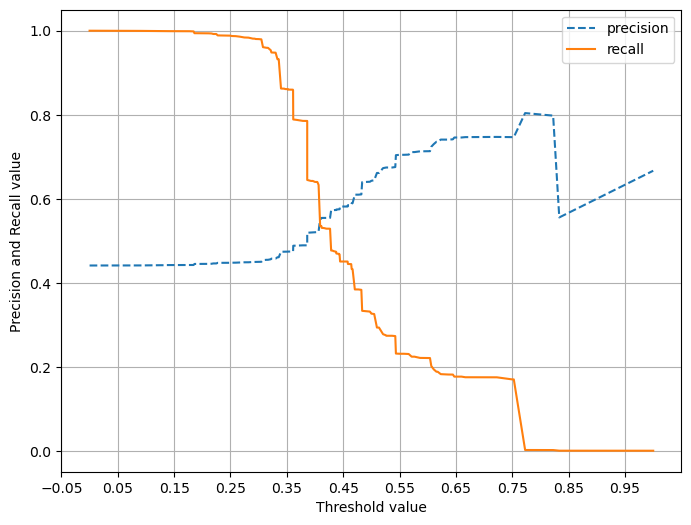

In [54]:
precision_recall_curve_plot(y_test, dtc.predict_proba(X_test)[:, 1].reshape(-1, 1))

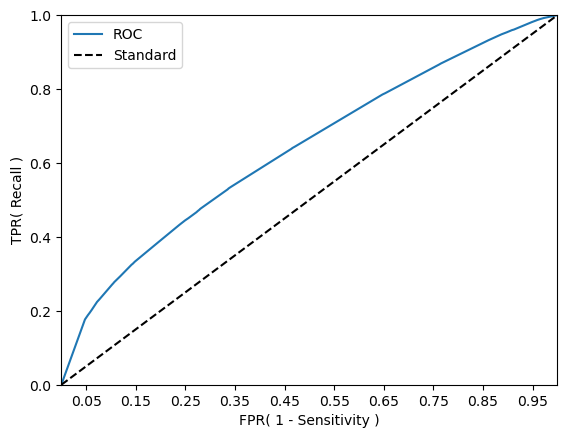

In [56]:
roc_curve_plot(y_test, dtc.predict_proba(X_test)[:, 1].reshape(-1, 1))